In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
import os
import cv2
import time
from tensorflow.keras.utils import Sequence
%matplotlib inline

In [2]:
devices=tf.config.experimental.list_physical_devices('GPU')
print("GPUS: ", len(devices))
tf.config.experimental.set_memory_growth(devices[0],True)

GPUS:  1


In [7]:
class DataGenerator(Sequence):

  def __init__(self, base_dir,base_dir2, output_size, shuffle=False, batch_size=10):
    self.base_dir = base_dir
    self.base_dir2 = base_dir2
    self.output_size = output_size
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.all_x = os.listdir(base_dir)
    self.all_y = os.listdir(base_dir2)
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indices = np.arange(len(self.all_x))
    if self.shuffle:
      np.random.shuffle(self.indices)

  def __len__(self):
    return int(len(self.all_x) / self.batch_size)

  def __getitem__(self, idx):
    X = np.empty((self.batch_size, *self.output_size, 3))
    Y = np.empty((self.batch_size, *self.output_size, 3))

    indices = self.indices[idx*(self.batch_size): (idx+1)*(self.batch_size)]
    

    for i,j in enumerate(indices):
      img_path = os.path.join(self.base_dir,self.all_x[j])
      img_path2 = os.path.join(self.base_dir2,self.all_y[j])
        
      img  = cv2.imread(img_path)
      img= cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),(128,128))
      img2 = cv2.imread(img_path2)
      img2= cv2.resize(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB),(128,128))
#       print(img_path,img_path2)

      X[i,] = img
      Y[i,] = img2
    X= X.astype('float32')/255
    Y= Y.astype('float32')/255

    return X, Y

In [4]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10,figsize=(20,20))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    img=img.astype(np.uint8)
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [5]:
train = DataGenerator('data/train_x/train_x','data/train_y/train_y',(128,128), batch_size=128, shuffle=False)
test  = DataGenerator('data/test_x/test_x','data/test_y/test_y',(128,128), batch_size=128, shuffle=False)

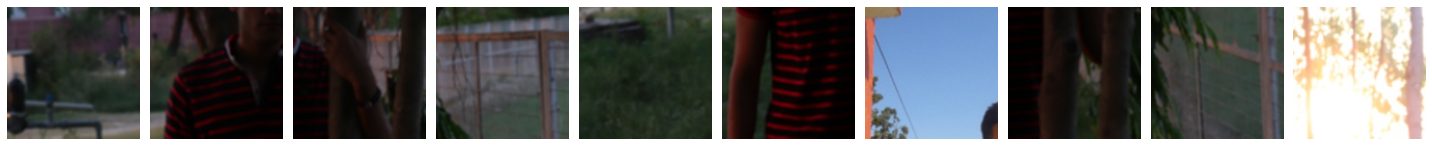

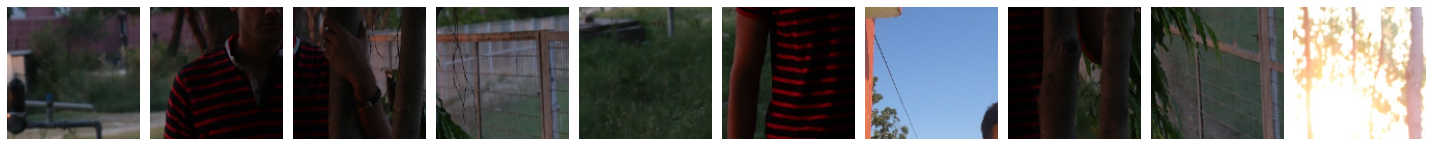

In [6]:
x,y=train[32]
plotImages(xx)
plotImages(yy)

In [8]:
def conv_operation(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def conv_transpose_operation(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deblurring_autoencoder():
   dae_inputs = Input(shape=(128,128,3), name='dae_input')
   conv_block1 = conv_operation(dae_inputs, 32, 3)
   conv_block2 = conv_operation(conv_block1, 64, 3)
   conv_block3 = conv_operation(conv_block2, 128, 3)
   conv_block4 = conv_operation(conv_block3, 256, 3)
   
   conv_block5 = conv_operation(conv_block4, 256, 3, 1)

   deconv_block1 = conv_transpose_operation(conv_block5, 256,3)
   merge1 = Concatenate()([conv_block3,deconv_block1])
   deconv_block2 = conv_transpose_operation(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = conv_transpose_operation(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = conv_transpose_operation(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3, kernel_size=3,padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   
   return Model(dae_inputs, dae_outputs, name='dae')

In [9]:
model= deblurring_autoencoder()

In [10]:
model.summary()

Model: "dae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dae_input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         dae_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________________________

In [11]:
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["mae","acc"])

In [12]:
NAME= f'Deblur-{time.time()}'
callbacks=[
    tf.keras.callbacks.TensorBoard(log_dir=f'logs\{NAME}'),
    ModelCheckpoint('deblur_my_shit.h5',verbose=1,save_best_only=True,save_weights_only=True)
]

In [13]:
model.fit(
    train,
    epochs=300,
    verbose=1,
    callbacks=callbacks
)

  ...
    to  
  ['...']
Train for 78 steps
Epoch 1/300
78/78 [==============================] - 50s 645ms/step - loss: -67.6603 - mae: 121.7886 - acc: 9.6241e-04
Epoch 2/300
78/78 [==============================] - 48s 611ms/step - loss: -237.3540 - mae: 121.6589 - acc: 9.6907e-04
Epoch 3/300
78/78 [==============================] - 48s 620ms/step - loss: -391.7369 - mae: 121.6011 - acc: 0.0010
Epoch 4/300
78/78 [==============================] - 49s 623ms/step - loss: -569.0354 - mae: 121.5718 - acc: 0.0011
Epoch 5/300
78/78 [==============================] - 48s 621ms/step - loss: -772.2011 - mae: 121.5495 - acc: 0.0010
Epoch 6/300
78/78 [==============================] - 49s 628ms/step - loss: -994.8504 - mae: 121.5307 - acc: 0.0011
Epoch 7/300
78/78 [==============================] - 49s 627ms/step - loss: -1228.0402 - mae: 121.5213 - acc: 0.0011
Epoch 8/300
78/78 [==============================] - 49s 628ms/step - loss: -1474.1272 - mae: 121.5122 - acc: 0.0011
Epoch 9/300
78/78 [

78/78 [==============================] - 49s 630ms/step - loss: -8529.4422 - mae: 121.4003 - acc: 0.0014
Epoch 29/300
78/78 [==============================] - 49s 630ms/step - loss: -8965.7129 - mae: 121.3971 - acc: 0.0014
Epoch 30/300
58/78 [=====================>........] - ETA: 12s - loss: -9372.1793 - mae: 122.0306 - acc: 0.0016

KeyboardInterrupt: 